# Vizualisation of passengers versus delay

### definition of functions for reading and preprocessing data

In [1]:
import pandas as pd 

######################
##  Reading traffic data
#######################
def get_traffic_data():
    input_file = 'C:/Users/AbdouAA/Work Folders/Documents/GitHub/k2-respunkt/data/RST_2015_v38_42.csv'
    traffic_data = pd.read_csv(input_file, delimiter=';')
    return traffic_data


######################
##  Reading demand data
#######################
def get_demand_data():
    # load dataset
    input_file = 'C:/Users/AbdouAA/Work Folders/Documents/GitHub/k2-respunkt/data/OD_data_dynamic.xlsx'
    df_static = pd.read_excel(input_file, sheet_name='Static', index_col=0, header=0)

    # Extract headers and index from the static data
    headers = df_static.columns
    index = df_static.index

    # Number of time periods (every 15 minutes during a full day)
    nb_time_periods = int(24 * 60 / 15)  # 96 periods

    # Initialize a dictionary to store DataFrames for each time period
    df_sheets = {}

    # Read specific sheets by index
    for t in range(nb_time_periods):
        sheet_name = f"Sheet{t+1}"  # Assuming sheet names are "Sheet1", "Sheet2", ..., "Sheet96"
        df_temp = pd.read_excel(input_file, sheet_name=sheet_name, header=None)  # Read without headers
        
        # Assign the headers and index from the static data
        df_temp.columns = headers
        df_temp.index = index
        
        # Store the DataFrame in the dictionary
        df_sheets[t] = df_temp
    return df_sheets

## Function to update/adjust static OD data for the specific studied line between Nyh and Bål
# Groups of stations
#C_stations = ['Äs', 'Åbe', 'Sst', 'Cst', 'Ke'] # central stations
def update_OD_Nyh_Bal(df):
    # Define station groups
    R35_stations = ['Nyh', 'Gdv', 'Ngd', 'Öso', 'Ssä', 'Hfa', 'Ts', 'Kda', 'Vhe', 'Jbo', 'Hnd', 'Skg', 'Tåd', 'Fas'] # eastern/right stations of line 35
    L35_stations = ['Sub', 'Spå', 'Bkb', 'Jkb', 'Khä', 'Kän', 'Bro', 'Bål'] # western/left stations of line 35
    R36_stations = ['Söc', 'Söd', 'Söu', 'Tul', 'Tu', 'Öte', 'Flb', 'Gn', 'Hu', 'Mö', 'Rön', 'Sta'] # eastern/right stations of line 36
    L36_stations = ['Sol', 'So', 'Udl', 'Upv', 'U', 'Hel', 'Hgv' , 'Kn', 'Mr', 'Nvk', 'Rs', 'R'] # western/left stations of line 36

    # Create a copy of the DataFrame to avoid modifying the original
    df_updated = df.copy()
    
    # Process trips from 35L to 36L
    for origin in L35_stations:
        for destination in L36_stations:
            df_updated.at[origin, 'Ke'] += df.at[origin, destination]
            df_updated.at[origin, destination] = 0
    
    # Process trips from 35L to 36R
    for origin in L35_stations:
        for destination in R36_stations:
            df_updated.at[origin, 'Äs'] += df.at[origin, destination]
            df_updated.at[origin, destination] = 0
            
    # Process trips from 35R to 36L
    for origin in R35_stations:
        for destination in L36_stations:
            df_updated.at[origin, 'Ke'] += df.at[origin, destination]
            df_updated.at[origin, destination] = 0
    
    # Process trips from 35R to 36R
    for origin in R35_stations:
        for destination in R36_stations:
            df_updated.at[origin, 'Äs'] += df.at[origin, destination]
            df_updated.at[origin, destination] = 0
    
    # Process trips from 36L to 35L
    for origin in L36_stations:
        for destination in L35_stations:
            df_updated.at['Ke', destination] += df.at[origin, destination]
            df_updated.at[origin, destination] = 0
            
    # Process trips from 36L to 35R
    for origin in L36_stations:
        for destination in R35_stations:
            df_updated.at['Äs', destination] += df.at[origin, destination]
            df_updated.at[origin, destination] = 0
            
    # Process trips from 36R to 35L
    for origin in R36_stations:
        for destination in L35_stations:
            df_updated.at['Ke', destination] += df.at[origin, destination]
            df_updated.at[origin, destination] = 0
    
    # Process trips from 36R to 35R
    for origin in R36_stations:
        for destination in R35_stations:
            df_updated.at['Äs', destination] += df.at[origin, destination]
            df_updated.at[origin, destination] = 0
    
    return df_updated

### Reading and preprocessing data

In [2]:
# read traffic data
df_traffic = get_traffic_data()

# List of columns to drop
columns_to_drop = [
    "Tågordning uppdrag",
    "Tågslag",
    "Avgångsplats",
    "Ankomstplats",
    "Första platssignatur för uppdrag",
    "Sista platssignatur för uppdrag",
    "Inställelseorsakskod",
    "Inställelseorsak",
    "Dragfordonsid",
    "Framförda tågkm",
    "Rapporterad tågvikt",
    "Rapporterad tåglängd",
    "Antal rapporterade hjulaxlar",
    "Antal rapporterade vagnar",
    "Inställtflagga"
]
# drop columns
df_traffic_filtered = df_traffic.drop(columns_to_drop, axis=1)

# rename the remaining columns, to remove space so that I can use pandas indexing
# Dictionary mapping old column names to new column names
columns_rename = {
    "Tåguppdrag": "Taguppdrag",
    "Tågnr": "Tagnr",
    "Datum (PAU)": "Datum",
    "UppehållstypAvgång": "UppehallstypAvgang",
    "UppehållstypAnkomst": "UppehallstypAnkomst",
    "Delsträckanummer": "Delstrackanummer",
    "Första platssignatur": "Forsta_platssignatur",
    "Sista platssignatur": "Sista_platssignatur",
    "Från platssignatur": "Fran_platssignatur",
    "Till platssignatur": "Till_platssignatur",
    "Sträcka med riktning": "Stracka_med_riktning",
    "Ankomsttid": "Ankomsttid",
    "Avgångstid": "Avgangstid",
    "Planerad ankomsttid": "Planerad_ankomsttid",
    "Planerad avgångstid": "Planerad_avgangstid",
    "Planeringsstatus": "Planeringsstatus"
}

# Rename the columns
df_traffic_renamed_all = df_traffic_filtered.rename(columns=columns_rename)

df_traffic_renamed_all['Ankomsttid'] = pd.to_datetime(df_traffic_renamed_all['Ankomsttid'], errors='coerce')
df_traffic_renamed_all['Avgangstid'] = pd.to_datetime(df_traffic_renamed_all['Avgangstid'], errors='coerce')
df_traffic_renamed_all['Planerad_ankomsttid'] = pd.to_datetime(df_traffic_renamed_all['Planerad_ankomsttid'], errors='coerce')
df_traffic_renamed_all['Planerad_avgangstid'] = pd.to_datetime(df_traffic_renamed_all['Planerad_avgangstid'], errors='coerce')

### Process traffic data

In [3]:
# Helper function to get direction
# +1 if going north
# -1 if going south
def get_direction(from_station, to_station, stations_south_to_north):
    if stations_south_to_north.index(from_station) < stations_south_to_north.index(to_station):
        return 1 # to the north
    elif stations_south_to_north.index(from_station) > stations_south_to_north.index(to_station):
        return -1 # to the south
    else:
        return 0
    
# function returning the index of the time period given a time
def get_t_float(time):
    return time.hour * 4 + time.minute / 15
def get_t_int(time):
    return int(time.hour * 4 + time.minute/15)

## append delay 
df_traffic_renamed_all.loc[:,"dep_delay"] = df_traffic_renamed_all["Planerad_ankomsttid"]-df_traffic_renamed_all["Ankomsttid"] 
df_traffic_renamed_all.loc[:,"arr_delay"] = df_traffic_renamed_all["Planerad_avgangstid"]-df_traffic_renamed_all["Avgangstid"]

# Lägg till kolumn för tidsperiod för avgång
df_traffic_renamed_all.loc[:, 'dep_t_int'] = df_traffic_renamed_all['Planerad_avgangstid'].apply(get_t_int)

# Lägg till kolumn för tidsperiod för ankomst
df_traffic_renamed_all.loc[:, 'arr_t_int'] = df_traffic_renamed_all['Planerad_ankomsttid'].apply(get_t_int)


# Function to convert timedelta to minutes, negative values and NaT to zero
def timedelta_to_minutes(td):
    if pd.isna(td) or td.total_seconds() < 0:
        return 0
    else:
        return td.total_seconds() / 60

# Apply the function using .loc[]
df_traffic_renamed_all.loc[:, 'dep_delay_minutes'] = df_traffic_renamed_all['dep_delay'].apply(timedelta_to_minutes)
df_traffic_renamed_all.loc[:, 'arr_delay_minutes'] = df_traffic_renamed_all['arr_delay'].apply(timedelta_to_minutes)

# Group by 'dep_t_int' and sum the 'dep_delay_minutes'
grouped_delays = df_traffic_renamed_all.groupby('dep_t_int')['dep_delay_minutes'].sum().reset_index()

# Rename the columns for clarity
grouped_delays.columns = ['time_period', 'total_dep_delay_minutes']

#### Remove/merge observations at intermediate non-stopping points (points not in the studied line)

In [4]:
# Initial filtering: Remove rows where both 'UppehallstypAvgang' and 'UppehallstypAnkomst' are 'Passage'
df_traffic_renamed = df_traffic_renamed_all[
    ~((df_traffic_renamed_all['UppehallstypAvgang'] == 'Passage') & 
      (df_traffic_renamed_all['UppehallstypAnkomst'] == 'Passage'))
]

# Identify rows with 'Passage' in either 'UppehallstypAvgang' or 'UppehallstypAnkomst'
passage_rows_avg = df_traffic_renamed[df_traffic_renamed['UppehallstypAvgang'] == 'Passage']
passage_rows_ank = df_traffic_renamed[df_traffic_renamed['UppehallstypAnkomst'] == 'Passage']

# Find the common train groups with 'Passage' in both avgång and ankomst
unique_ids = set(zip(passage_rows_avg['Taguppdrag'], passage_rows_avg['Datum'], passage_rows_avg['Tagnr'])) & \
             set(zip(passage_rows_ank['Taguppdrag'], passage_rows_ank['Datum'], passage_rows_ank['Tagnr']))

merged_rows = []

# Iterate over each unique (Taguppdrag, Datum, Tagnr) tuple
for tag_id, datum, tagnr in unique_ids:
    # Get the corresponding rows
    rows_avg = passage_rows_avg[(passage_rows_avg['Taguppdrag'] == tag_id) & 
                                (passage_rows_avg['Datum'] == datum) & 
                                (passage_rows_avg['Tagnr'] == tagnr)].sort_values(by="Delstrackanummer")
    
    rows_ank = passage_rows_ank[(passage_rows_ank['Taguppdrag'] == tag_id) & 
                                (passage_rows_ank['Datum'] == datum) & 
                                (passage_rows_ank['Tagnr'] == tagnr)].sort_values(by="Delstrackanummer")
    
    # Iterate over each row in the avgång and ankomst sets
    for i in range(len(rows_ank)):
        # Merge the rows according to the specified rules
        merged_row = rows_avg.iloc[i].copy()
        merged_row['UppehallstypAvgang'] = rows_ank['UppehallstypAvgang'].iloc[i]
        merged_row['UppehallstypAnkomst'] = rows_avg['UppehallstypAnkomst'].iloc[i]
        merged_row['Delstrackanummer'] = rows_ank['Delstrackanummer'].iloc[i]
        merged_row['Fran_platssignatur'] = rows_ank['Fran_platssignatur'].iloc[i]
        merged_row['Till_platssignatur'] = rows_avg['Till_platssignatur'].iloc[i]
        merged_row['Ankomsttid'] = rows_avg['Ankomsttid'].iloc[i]
        merged_row['Avgangstid'] = rows_ank['Avgangstid'].iloc[i]
        merged_row['Planerad_ankomsttid'] = rows_avg['Planerad_ankomsttid'].iloc[i]
        merged_row['Planerad_avgangstid'] = rows_ank['Planerad_avgangstid'].iloc[i]

        # Add the merged row to the list
        merged_rows.append(merged_row)

# Create a DataFrame from the merged rows
merged_rows_df = pd.DataFrame(merged_rows)

# Remove the original 'Passage' rows from the DataFrame
traffic_data_filtered = df_traffic_renamed[
    ~((df_traffic_renamed['UppehallstypAvgang'] == 'Passage') | 
      (df_traffic_renamed['UppehallstypAnkomst'] == 'Passage'))
]

# Add the merged rows back into the DataFrame
traffic_data_filtered = pd.concat([traffic_data_filtered, merged_rows_df], ignore_index=True)

# Sort by 'Datum', 'Taguppdrag', 'Tagnr', and 'Delstrackanummer'
traffic_data_filtered.sort_values(by=['Datum', 'Taguppdrag', 'Tagnr', 'Delstrackanummer'], inplace=True)

# Re-adjust 'Delstrackanummer' within each group to be consecutive
traffic_data_filtered['Delstrackanummer'] = traffic_data_filtered.groupby(['Datum', 'Taguppdrag', 'Tagnr']).cumcount() + 1

# Extract the date part only
dates_planned = traffic_data_filtered['Planerad_avgangstid'].dt.date

# Identify trains departing before 2 am on 2015-09-14
early_morning_trains = traffic_data_filtered[
    (dates_planned == pd.to_datetime('2015-09-14').date()) & 
    (traffic_data_filtered['Planerad_avgangstid'].dt.hour < 2)
]

# Remove the identified trains
traffic_data_filtered = traffic_data_filtered.loc[~traffic_data_filtered.index.isin(early_morning_trains.index)]

## correct missing Ankomsttid when Avgangstid exist using Avgangstid and Planerad_avgangstid and Planerad_ankomsttid
# Step 1: Filter out only planned (non-cancelled) trains
df_traffic_no_cancellation = traffic_data_filtered[traffic_data_filtered["Planeringsstatus"] == "P"].copy()

# Step 2: Correct missing Ankomsttid using Avgangstid
# Filter rows where Ankomsttid is missing but Avgangstid exists
missing_arrival_mask = df_traffic_no_cancellation['Ankomsttid'].isna() & df_traffic_no_cancellation['Avgangstid'].notna()

# Calculate the difference between Planerad_ankomsttid and Planerad_avgangstid (in minutes)
df_traffic_no_cancellation['planned_runtime'] = (df_traffic_no_cancellation['Planerad_ankomsttid'] - df_traffic_no_cancellation['Planerad_avgangstid']).dt.total_seconds() / 60

# Calculate the expected Ankomsttid by adding the time difference to Avgangstid
df_traffic_no_cancellation.loc[missing_arrival_mask, 'Ankomsttid'] = df_traffic_no_cancellation.loc[missing_arrival_mask, 'Avgangstid'] + pd.to_timedelta(df_traffic_no_cancellation.loc[missing_arrival_mask, 'planned_runtime'], unit='m')

actual_or_planned = 'planned'
if actual_or_planned != 'planned':
    # if actual

    # Step 1: Group the data by 'Datum', 'Taguppdrag', 'Tagnr'
    grouped = df_traffic_no_cancellation.groupby(['Datum', 'Taguppdrag', 'Tagnr'])

    # Step 2: Identify groups where any 'Ankomsttid' or 'Avgangstid' is missing
    groups_with_missing_values = grouped.filter(lambda group: group[['Ankomsttid', 'Avgangstid']].isnull().any().any())

    # Step 3: Remove those groups from the original DataFrame
    df_traffic_no_cancellation = df_traffic_no_cancellation[~df_traffic_no_cancellation.index.isin(groups_with_missing_values.index)]

    # Step 5: Reset index if needed
    df_traffic_no_cancellation = df_traffic_no_cancellation.reset_index(drop=True)


### Get demand data

In [5]:
# Define valid station values between Nyh and Bål
studied_line_35 = ['Nyh', 'Gdv', 'Ngd', 'Öso', 'Ssä', 'Hfa', 'Ts', 'Kda', 'Vhe', 'Jbo', 'Hnd', 'Skg', 'Tåd', 'Fas', 'Äs',
                'Åbe', 'Sst', 'Cst', 'Ke', 'Sub', 'Spå', 'Bkb', 'Jkb', 'Khä', 'Kän', 'Bro', 'Bål']

# read demand data
df_demand = get_demand_data()

# Number of time periods (every 15 minutes during a full day)
nb_time_periods = int(24 * 60 / 15)  # 96 periods
results = []
for t in range(nb_time_periods):
    # Update the OD matrix
    df_temp = update_OD_Nyh_Bal(df_demand[t])
    
    # Iterate over the updated DataFrame
    for origin in studied_line_35:
        for destination in studied_line_35:
            n_pass = df_temp.at[origin, destination]
            results.append({'from': origin, 'to': destination, 'time_period': t, 'n_pass': n_pass})

# Create DataFrame from results
df_demand_updated = pd.DataFrame(results)

In [6]:
# Group by 'time_period' and sum the 'n_pass'
df_demand_grouped = df_demand_updated.groupby('time_period')['n_pass'].sum().reset_index()

# Rename the columns for clarity
df_demand_grouped.columns = ['time_period', 'total_n_passengers']

### Merging passenger and traffic data

In [7]:
# Merge df_demand_grouped and grouped_delays on 'time_period'
merged_df = pd.merge(df_demand_grouped, grouped_delays, on='time_period', how='outer')

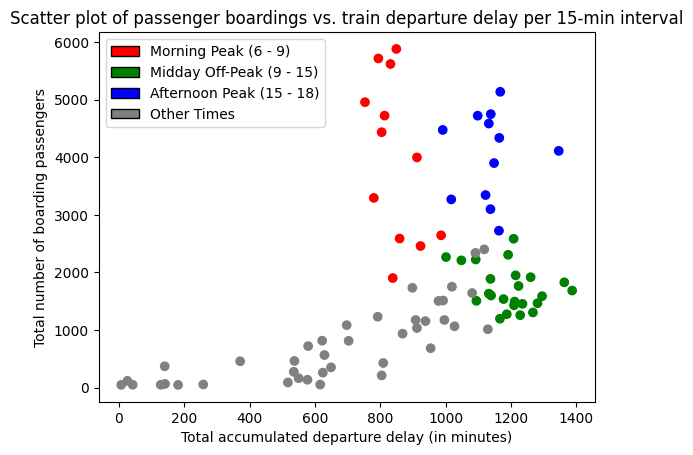

In [8]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Patch

# Define the time periods for peak and off-peak hours
peak_morning = range(6*4, 9*4)  # 6 AM to 9 AM
off_peak_midday = range(9*4, 15*4)  # 9 AM to 3 PM
peak_afternoon = range(15*4, 18*4)  # 3 PM to 6 PM

# Assign colors based on time period
colors = []
for time_period in merged_df['time_period']:
    if time_period in peak_morning:
        colors.append('red')  # Morning peak
    elif time_period in off_peak_midday:
        colors.append('green')  # Off-peak midday
    elif time_period in peak_afternoon:
        colors.append('blue')  # Afternoon peak
    else:
        colors.append('gray')  # Other times

# Create scatter plot
plt.scatter(merged_df['total_dep_delay_minutes'], merged_df['total_n_passengers'], c=colors)
plt.xlabel('Total accumulated departure delay (in minutes)')
plt.ylabel('Total number of boarding passengers')
plt.title('Scatter plot of passenger boardings vs. train departure delay per 15-min interval')

# Create legend
legend_elements = [
    Patch(facecolor='red', edgecolor='black', label='Morning Peak (6 - 9)'),
    Patch(facecolor='green', edgecolor='black', label='Midday Off-Peak (9 - 15)'),
    Patch(facecolor='blue', edgecolor='black', label='Afternoon Peak (15 - 18)'),
    Patch(facecolor='gray', edgecolor='black', label='Other Times')
]

plt.legend(handles=legend_elements, loc='upper left')
# Show plot
plt.show()